[I 2025-03-23 15:30:46,798] A new study created in memory with name: no-name-b1367467-cd3f-4dcb-ab32-b839c036b4ba


Baseline Model Accuracy: 0.805


f:\Aarzoo\Mtech AI\Recordings\sem3\MLOPS\Assignment 2\MLOPS-bits-Group41-Assignment2\venv\Lib\site-packages\optuna\distributions.py:684: UserWarning: The distribution is specified by [0.01, 0.3] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 0.26].
  warnings.warn(
[I 2025-03-23 15:31:31,527] Trial 0 finished with value: 0.805 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.21000000000000002}. Best is trial 0 with value: 0.805.
f:\Aarzoo\Mtech AI\Recordings\sem3\MLOPS\Assignment 2\MLOPS-bits-Group41-Assignment2\venv\Lib\site-packages\optuna\distributions.py:684: UserWarning: The distribution is specified by [0.01, 0.3] and step=0.05, but the range is not divisible by `step`. It will be replaced by [0.01, 0.26].
  warnings.warn(
[I 2025-03-23 15:32:21,277] Trial 1 finished with value: 0.805 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.21000000000000002}. Best is trial 0 with value: 0.805.
f:\Aar

Final Model Accuracy: 0.8267
Best Hyperparameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.26}


 97%|=================== | 484/500 [00:16<00:00]       

SHAP Summary Plot saved as shap_summary.html. Open it in a browser to view.


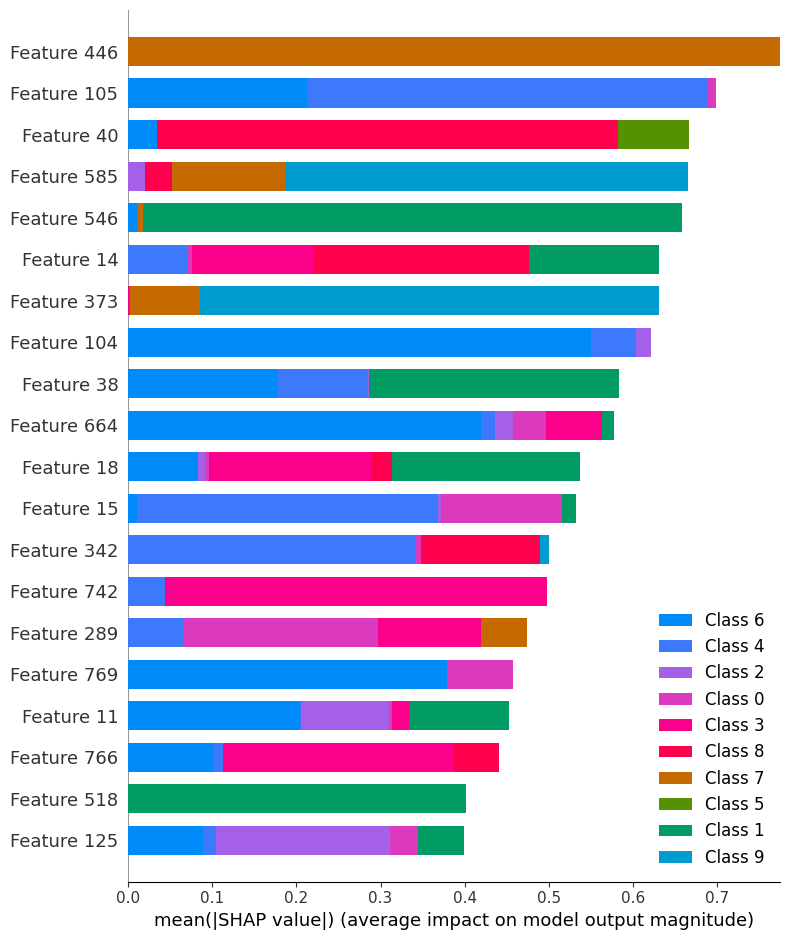

In [2]:
import numpy as np
import pandas as pd
import optuna
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import fashion_mnist

# Load Fashion MNIST and Increase Dataset Size
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test, y_train, y_test = X_train[:1000], X_test[:300], y_train[:1000], y_test[:300]  # Increased size

# Flatten and Normalize
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Split into Train/Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Define Model Selection Using XGBoost
model = xgb.XGBClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=1)
model.fit(X_train, y_train)
print("Baseline Model Accuracy:", accuracy_score(y_val, model.predict(X_val)))

# Hyperparameter Tuning using Optuna
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 150, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 12, step=3)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, step=0.05)

    model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42, n_jobs=1)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Train Best Model with Optimized Hyperparameters
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=1)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

# Final Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy:.4f}")
print("Best Hyperparameters:", best_params)

# Explainability with SHAP
explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_test[:50])  # Explain a small batch

# ✅ Save SHAP Summary Plot as HTML
plt.figure()
shap.summary_plot(shap_values, X_test[:50], show=False)
plt.savefig("shap_summary_plot.png", bbox_inches="tight")  # Save as PNG

# Convert the saved plot to an HTML file
shap_html = "shap_summary.html"
with open(shap_html, "w", encoding="utf-8") as f:
    f.write(f"<html><body><h1>SHAP Summary Plot</h1><img src='shap_summary_plot.png'></body></html>")

print(f"SHAP Summary Plot saved as {shap_html}.")


In [3]:
!pip install tpot

We now use tpot for hyperparameter and optuna to fine tune the model chosen by tpot

In [ ]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# --------- Load the Fashion MNIST dataset ---------
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# --------- Flatten the images ---------
x_train_flat = x_train.reshape(x_train.shape[0], -1)  
x_test_flat = x_test.reshape(x_test.shape[0], -1)  

# --------- Standardize the data ---------
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

# --------- Split the data into training and validation sets ---------
x_train, x_val, y_train, y_val = train_test_split(x_train_scaled, y_train, test_size=0.2, random_state=42)

# --------- Model Selection with TPOT ---------
print("Starting model selection with TPOT...")
tpot = TPOTClassifier(generations=3, population_size=10, random_state=42, max_time_mins=30, n_jobs=1)
x_train_small, y_train_small = x_train[:1000], y_train[:1000]
tpot.fit(x_train_small, y_train_small)

validation_accuracy = tpot.score(x_val, y_val)
print(f"Validation Accuracy from TPOT: {validation_accuracy}")
tpot.export('best_model.py')

# --------- Hyperparameter Optimization with Optuna ---------
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    return accuracy_score(y_val, y_pred)

print("\nStarting hyperparameter optimization with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters found by Optuna:", study.best_params)
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(x_train, y_train)

y_test_pred = final_model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy with Optimized Hyperparameters: {test_accuracy}")

# --------- Plot and Save Optimization History ---------
trials_df = study.trials_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(trials_df['number'], trials_df['value'], label='Validation Accuracy', marker='o')
plt.title("Optuna Hyperparameter Optimization History")
plt.xlabel("Trial Number")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)

# Save the plot as an image
plot_filename = "optuna_optimization_plot.png"
plt.savefig(plot_filename, bbox_inches="tight")
plt.close()

# Save the plot as an HTML file
html_filename = "optuna_optimization_plot.html"
with open(html_filename, "w", encoding="utf-8") as f:
    f.write(f"<html><body><h1>Optuna Hyperparameter Optimization Plot</h1><img src='{plot_filename}'></body></html>")

print(f"Optimization plot saved as {html_filename}.")


f:\Aarzoo\Mtech AI\Recordings\sem3\MLOPS\Assignment 2\MLOPS-bits-Group41-Assignment2\venv\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Starting model selection with TPOT...
is_classifier
is_regressor
is_classifier


f:\Aarzoo\Mtech AI\Recordings\sem3\MLOPS\Assignment 2\MLOPS-bits-Group41-Assignment2\venv\Lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
f:\Aarzoo\Mtech AI\Recordings\sem3\MLOPS\Assignment 2\MLOPS-bits-Group41-Assignment2\venv\Lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.
